In [17]:
%pip install scikit-learn numpy pandas tensorflow yfinance -q

Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [19]:
def create_sequences(data, lookback=30):
    """
    data: 2D array (n_samples, 1) – already scaled.
    Returns:
        X: (num_samples, lookback, 1)
        y: (num_samples,)
    """
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        y.append(data[i][0])
    return np.array(X), np.array(y)

In [20]:
symbol = "BTC-USD"
train_start = "2020-01-01"
train_end   = "2024-01-01"  # end date is exclusive

data = yf.download(symbol, start=train_start, end=train_end)

data = data.reset_index()
data.rename(columns={"Date": "Time", "Close": "Price"}, inplace=True)

train_df = data[["Time", "Price"]].copy()
train_df["Return"] = train_df["Price"].pct_change()
train_df.dropna(inplace=True)

train_df.head()

C:\Users\amhos\AppData\Local\Temp\ipykernel_34636\819659283.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=train_start, end=train_end)
[*********************100%***********************]  1 of 1 completed


Price,Time,Price,Return
Ticker,,BTC-USD,
1,2020-01-02,6985.470215,-0.029819
2,2020-01-03,7344.884277,0.051452
3,2020-01-04,7410.656738,0.008955
4,2020-01-05,7411.317383,0.000089
5,2020-01-06,7769.219238,0.048291


In [21]:
LOOKBACK = 30

returns = train_df["Return"].values.reshape(-1, 1)

scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns)

X, y = create_sequences(returns_scaled, lookback=LOOKBACK)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1430, 30, 1)
y shape: (1430,)


In [22]:
split = int(len(X) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (1144, 30, 1) (1144,)
Test : (286, 30, 1) (286,)


In [23]:
model = Sequential()
model.add(LSTM(32, input_shape=(LOOKBACK, 1)))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


G:\UNI\Trading_Practice\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.2919 - val_loss: 0.7016
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2892 - val_loss: 0.7024
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2855 - val_loss: 0.7028
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2836 - val_loss: 0.7029
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2849 - val_loss: 0.7026
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2804 - val_loss: 0.7045


In [24]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Test MSE on train period:", mse)

y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_unscaled = scaler.inverse_transform(y_pred).flatten()

signals = np.where(y_pred_unscaled > 0, 1, 0)
strategy_returns = signals * y_test_unscaled
equity_curve = (1.0 + strategy_returns).cumprod()

test_start_index = LOOKBACK + split
test_times = train_df["Time"].iloc[test_start_index:].reset_index(drop=True)

results_in_sample = pd.DataFrame({
    "Time": test_times,
    "Real_Return": y_test_unscaled,
    "Pred_Return": y_pred_unscaled,
    "Signal": signals,
    "Strategy_Return": strategy_returns,
    "Equity": equity_curve
})

results_in_sample.head()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test MSE on train period: 0.3481852993051238


,Time,Real_Return,Pred_Return,Signal,Strategy_Return,Equity
0,2023-03-21,0.014714,0.004711,1,0.014714,1.014714
1,2023-03-22,-0.030820,0.004606,1,-0.030820,0.983441
2,2023-03-23,0.037592,0.004369,1,0.037592,1.020410
3,2023-03-24,-0.029671,0.004000,1,-0.029671,0.990134
4,2023-03-25,0.000052,0.003762,1,0.000052,0.990185


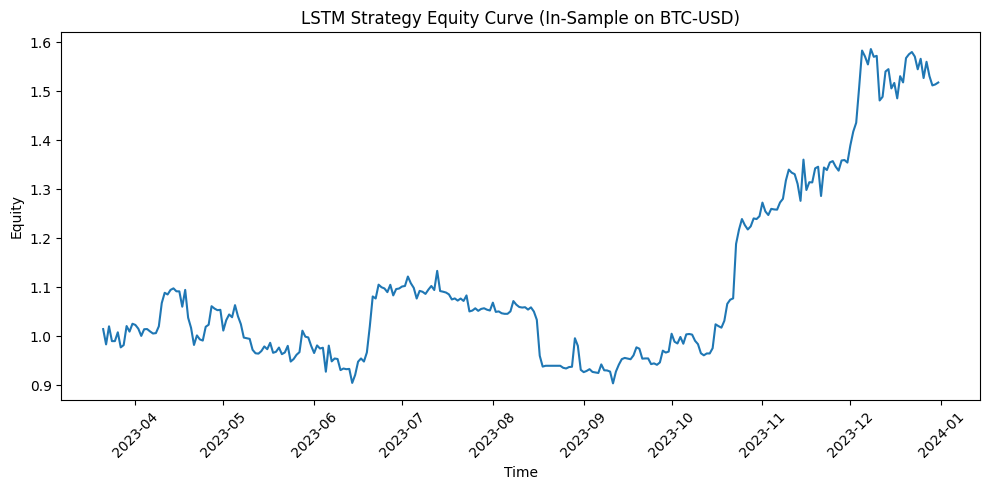

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(results_in_sample["Time"], results_in_sample["Equity"])
plt.title(f"LSTM Strategy Equity Curve (In-Sample on {symbol})")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
oos_start = "2024-01-01"
oos_end   = "2025-01-01"  # adjust as you like

data_oos = yf.download(symbol, start=oos_start, end=oos_end)

data_oos = data_oos.reset_index()
data_oos.rename(columns={"Date": "Time", "Close": "Price"}, inplace=True)

test_df = data_oos[["Time", "Price"]].copy()
test_df["Return"] = test_df["Price"].pct_change()
test_df.dropna(inplace=True)

test_df.head()

C:\Users\amhos\AppData\Local\Temp\ipykernel_34636\663658141.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_oos = yf.download(symbol, start=oos_start, end=oos_end)
[*********************100%***********************]  1 of 1 completed


Price,Time,Price,Return
Ticker,,BTC-USD,
1,2024-01-02,44957.968750,0.017901
2,2024-01-03,42848.175781,-0.046928
3,2024-01-04,44179.921875,0.031081
4,2024-01-05,44162.691406,-0.000390
5,2024-01-06,43989.195312,-0.003929


In [27]:
new_returns = test_df["Return"].values.reshape(-1, 1)

new_returns_scaled = scaler.transform(new_returns)

X_new, y_new = create_sequences(new_returns_scaled, lookback=LOOKBACK)

print("Out-of-sample X_new shape:", X_new.shape)
print("Out-of-sample y_new shape:", y_new.shape)

Out-of-sample X_new shape: (335, 30, 1)
Out-of-sample y_new shape: (335,)


In [28]:
y_new_pred = model.predict(X_new)

y_new_unscaled = scaler.inverse_transform(y_new.reshape(-1, 1)).flatten()
y_new_pred_unscaled = scaler.inverse_transform(y_new_pred).flatten()

signals_new = np.where(y_new_pred_unscaled > 0, 1, 0)
strategy_returns_new = signals_new * y_new_unscaled
equity_curve_new = (1.0 + strategy_returns_new).cumprod()

start_index_new = LOOKBACK
times_new = test_df["Time"].iloc[start_index_new:].reset_index(drop=True)

results_out_sample = pd.DataFrame({
    "Time": times_new,
    "Real_Return": y_new_unscaled,
    "Pred_Return": y_new_pred_unscaled,
    "Signal": signals_new,
    "Strategy_Return": strategy_returns_new,
    "Equity": equity_curve_new
})

print("Final equity on out-of-sample data:", equity_curve_new[-1])
results_out_sample.head()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Final equity on out-of-sample data: 2.014485534421074


,Time,Real_Return,Pred_Return,Signal,Strategy_Return,Equity
0,2024-02-01,0.011581,0.001848,1,0.011581,1.011581
1,2024-02-02,0.002556,0.001861,1,0.002556,1.014167
2,2024-02-03,-0.004483,0.001913,1,-0.004483,1.009620
3,2024-02-04,-0.009506,0.001893,1,-0.009506,1.000023
4,2024-02-05,0.001763,0.001788,1,0.001763,1.001786


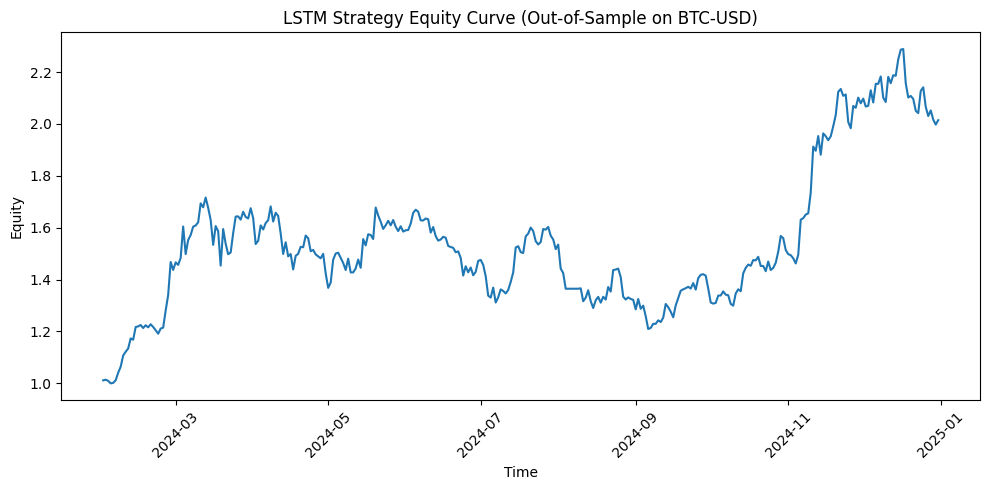

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(results_out_sample["Time"], results_out_sample["Equity"])
plt.title(f"LSTM Strategy Equity Curve (Out-of-Sample on {symbol})")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
